# Blood pressure in R

Just some plots from [blood_pressure.ipynb](./blood_pressure.ipynb) replicated in R 😊 To get R in Jupyter, `conda install -c r r-irkernel` was enough, if I remember right 🤔

In [1]:
library(ggplot2)
library(readxl)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
theme_set(theme_classic(base_size = 15))

In [3]:
blood_pressure <- read_xlsx("data/blood_pressure.xlsx")

blood_pressure$Meter <- factor(
    blood_pressure$Meter,
    levels = c("Omron M3", "Sanitas SBC 22", "Boso Medicus X")
)

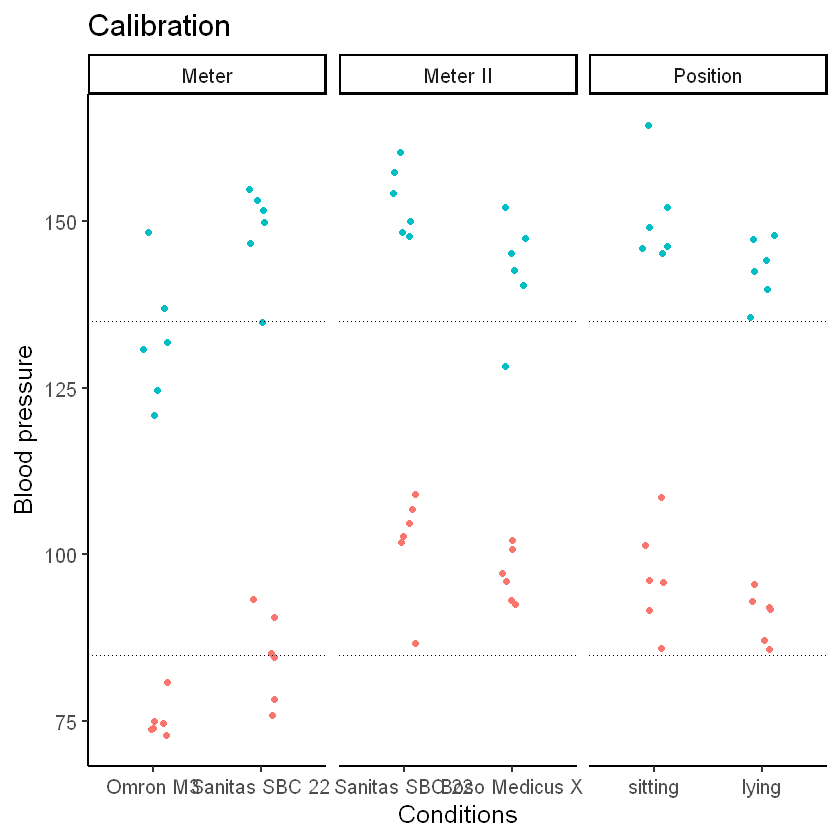

In [4]:
blood_pressure <- blood_pressure %>%
    mutate(Calibration = case_when(
        (blood_pressure$Timestamp > "2024-01-31" & blood_pressure$Timestamp < "2024-02-01") ~ "Meter",
        (blood_pressure$Timestamp > "2024-02-01" & blood_pressure$Timestamp < "2024-02-02") ~ "Position",
        (blood_pressure$Timestamp > "2024-02-26" & blood_pressure$Timestamp < "2024-02-27") ~ "Meter II"
    ))

calibration_of_meters <- rename(subset(blood_pressure, Calibration == "Meter"), variable = Meter)
calibration_of_positon <- rename(subset(blood_pressure, Calibration == "Position"), variable = Position)
calibration_of_meters_2 <- rename(subset(blood_pressure, Calibration == "Meter II"), variable = Meter)

rbind(
    select(calibration_of_meters, Sys, Dia, Calibration, variable),
    select(calibration_of_positon, Sys, Dia, Calibration, variable),
    select(calibration_of_meters_2, Sys, Dia, Calibration, variable)
) %>%
    pivot_longer(c(Sys, Dia), names_to = "Pressure") %>%
    ggplot(mapping = aes(x = variable, y = value, colour = Pressure)) + 
    geom_jitter(width = 0.125) + 
    geom_hline(yintercept = 85, linetype = "dotted", colour = "black") +
    geom_hline(yintercept = 135, linetype = "dotted", colour = "black") +
    facet_wrap("Calibration", scales = "free_x") + 
    theme(legend.position = "none") + 
    labs(x = "Conditions", y = "Blood pressure", title = "Calibration")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


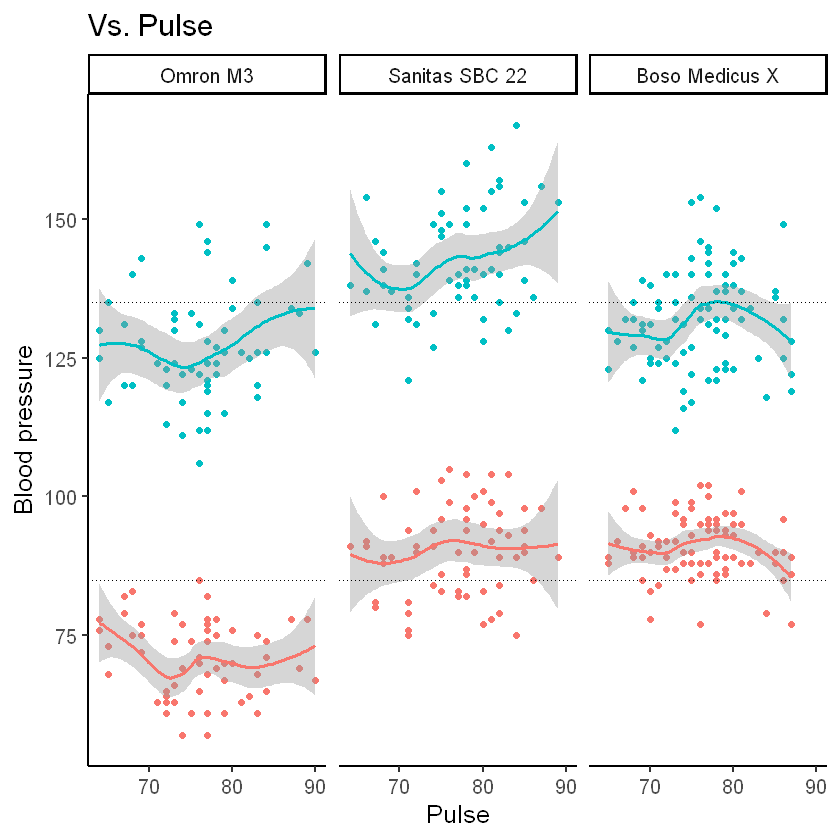

In [5]:
blood_pressure %>%
    subset(is.na(Calibration)) %>%
    pivot_longer(c(Sys, Dia), names_to = "Pressure") %>%
    ggplot(mapping = aes(x = Pulse, y = value, colour = Pressure)) + 
    geom_point() + 
    geom_smooth() +
    geom_hline(yintercept = 85, linetype = "dotted", colour = "black") +
    geom_hline(yintercept = 135, linetype = "dotted", colour = "black") +
    facet_wrap("Meter") + 
    theme(legend.position = "none") + 
    labs(y = "Blood pressure", title = "Vs. Pulse")

In [6]:
blood_pressure$Weekday <- weekdays(blood_pressure$Timestamp, abbreviate = TRUE)
blood_pressure$Weekday <- factor(
    blood_pressure$Weekday,
    levels = c("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
)

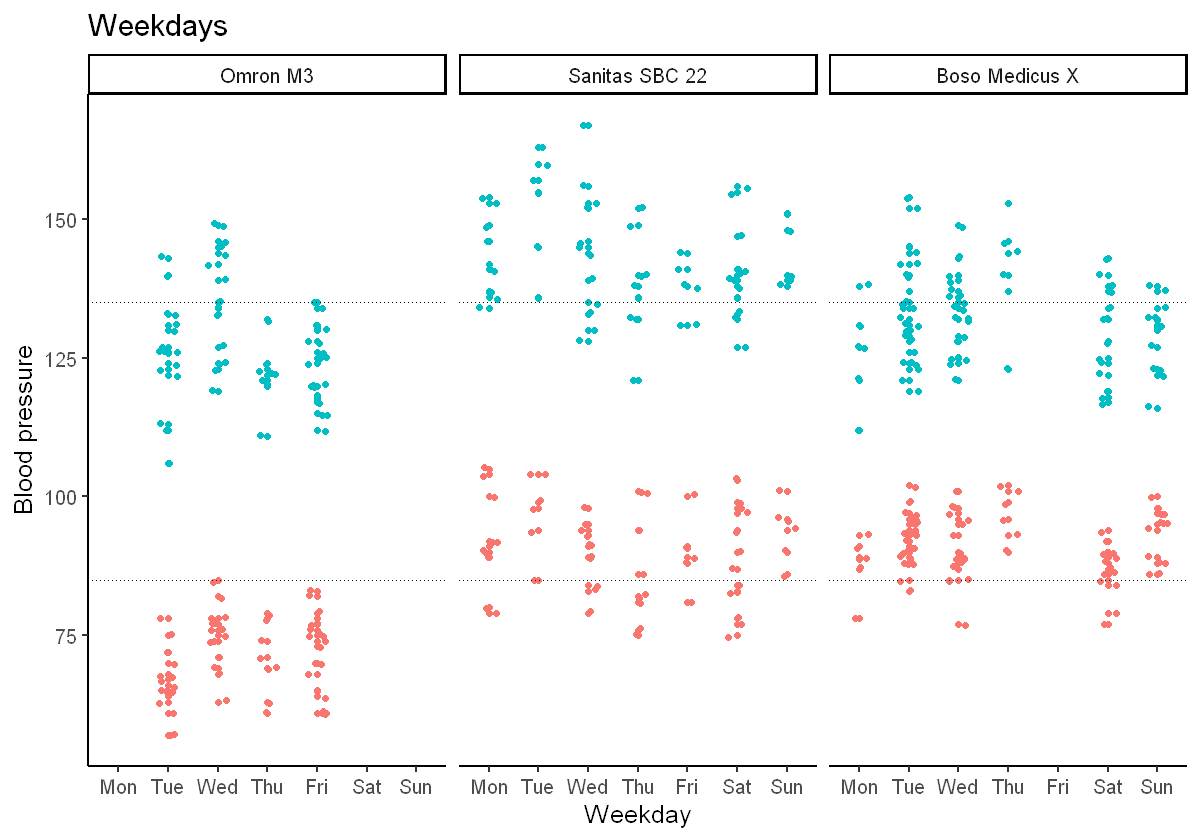

In [7]:
options(repr.plot.width=10, repr.plot.height=7)

blood_pressure %>%
    subset(is.na(Calibration)) %>%
    pivot_longer(c(Sys, Dia), names_to = "Pressure") %>%
    ggplot(mapping = aes(x = Weekday, y = value, colour = Pressure)) + 
    geom_point() + 
    geom_jitter(width = 0.2) +
    geom_hline(yintercept = 85, linetype = "dotted", colour = "black") +
    geom_hline(yintercept = 135, linetype = "dotted", colour = "black") +
    facet_wrap("Meter") + 
    theme(legend.position = "none") + 
    labs(y = "Blood pressure", title = "Weekdays")

In [8]:
blood_pressure$Time <- hour(blood_pressure$Timestamp) + minute(blood_pressure$Timestamp) / 60

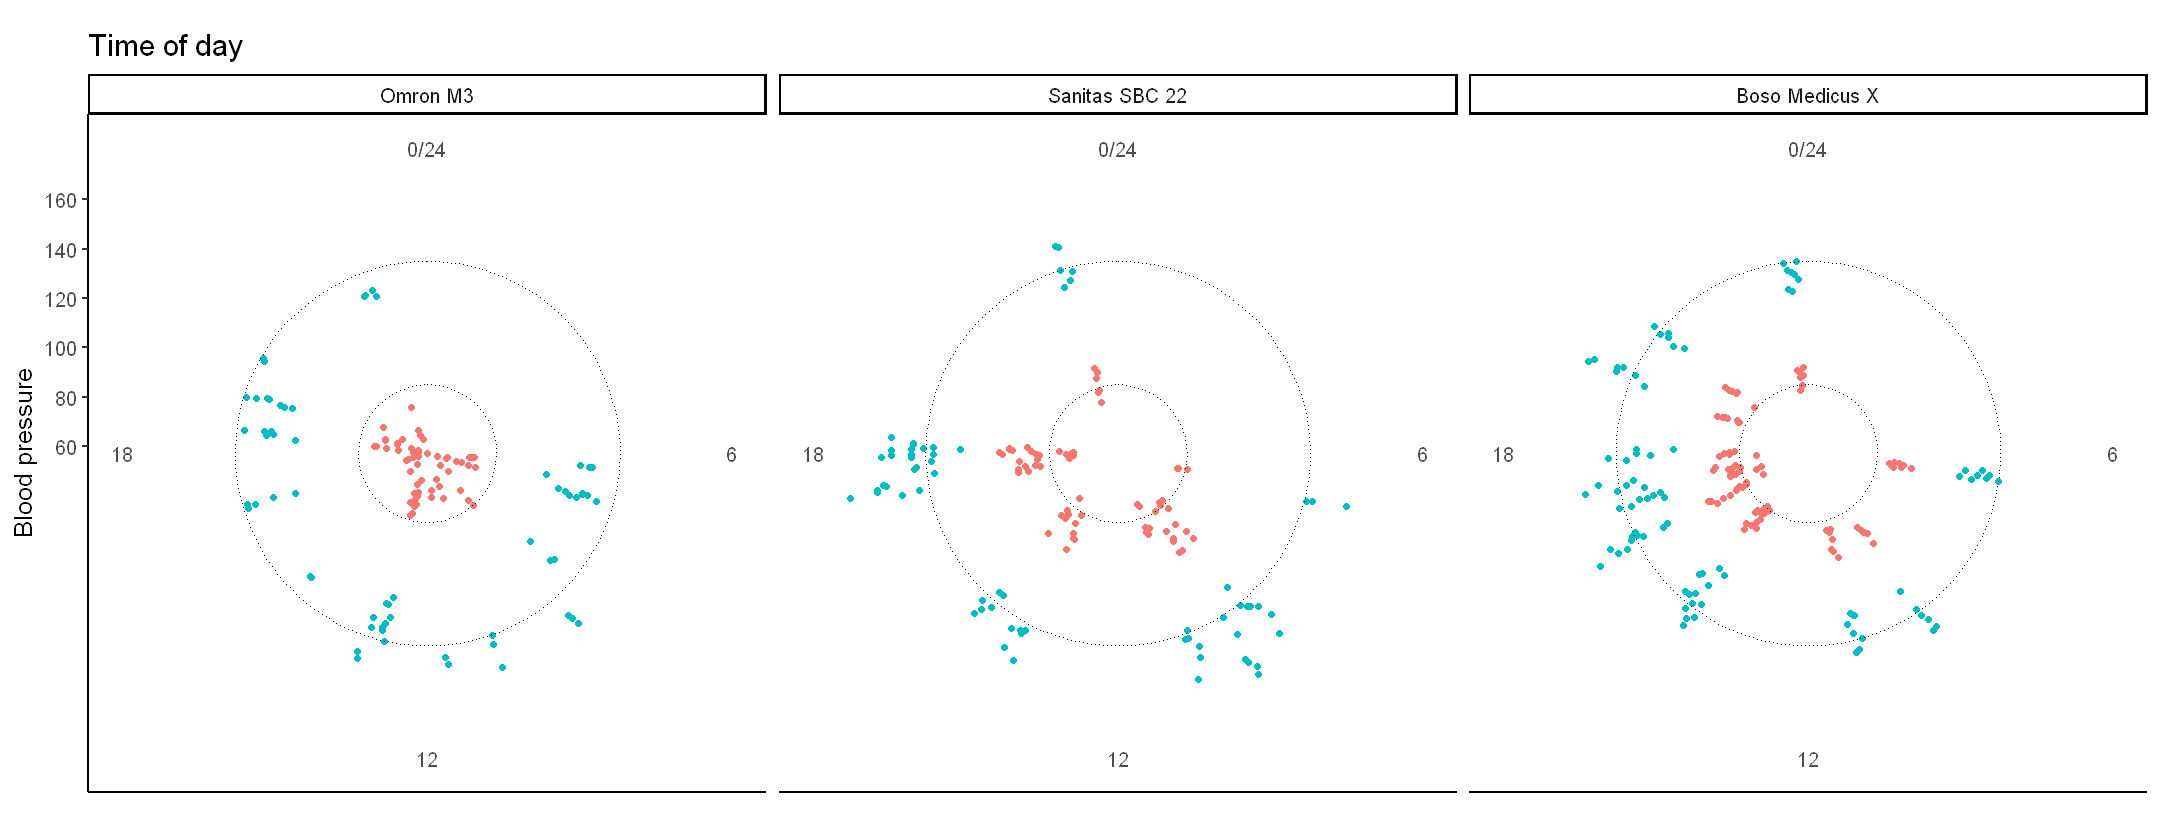

In [9]:
options(repr.plot.width = 18, repr.plot.height = 7)

blood_pressure %>%
    subset(is.na(Calibration)) %>%
    pivot_longer(c(Sys, Dia), names_to = "Pressure") %>%
    ggplot(mapping = aes(x = Time, y = value, colour = Pressure)) + 
    geom_point() +
    geom_hline(yintercept = 85, linetype = "dotted", colour = "black") +
    geom_hline(yintercept = 135, linetype = "dotted", colour = "black") +
    facet_wrap("Meter") + 
    theme(legend.position = "none") + 
    labs(y = "Blood pressure", x = NULL, title = "Time of day") +
    coord_polar(start = 0) +
    scale_x_continuous(limits = c(0, 24), breaks = seq(0, 24, by = 6))

In [10]:
analyse <- function(replicates) {
    rows = list()
    for (col in c("Sys", "Dia")) {
        rows = c(
            rows, 
            c(
                "Evaluation" = "Mean",
                "Kind" = col,
                "Blood Pressure" = mean(replicates[col])
            )
        )
    }

    # slice(replicates, 1:2)
    
    data.frame(rows)
}


measurements <- blood_pressure[
    order(blood_pressure$Side, blood_pressure$Meter, blood_pressure$Timestamp),
] %>% 
    group_by((c(0, diff(blood_pressure$Timestamp)) > 30) %>% cumsum) %>%
    analyse() %>%
    ungroup()

measurements

Warning message in mean.default(replicates[col]):
"argument is not numeric or logical: returning NA"
Warning message in mean.default(replicates[col]):
"argument is not numeric or logical: returning NA"


Evaluation,Kind,Blood.Pressure,Evaluation.1,Kind.1,Blood.Pressure.1
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Mean,Sys,NA,Mean,Dia,NA


In [11]:
to_vec(
    for( col in c("Sys", "Dia")) col
)

ERROR: Error in to_vec(for (col in c("Sys", "Dia")) col): could not find function "to_vec"


In [ ]:
rows = list()
for (col in c("Sys", "Dia")) {
    rows = c(rows, col)
}

rows

In [ ]:
data.frame(rows)